In [12]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm

from communicative_agent import CommunicativeAgent
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

In [13]:
ABX_NB_SAMPLES = 50
AGENT_ABX_DISTANCES = [
    {
        "sound_units": {
            "metric": "cosine",
            "weight": 1,
        }
    },
    {"art_estimated": {
            "metric": "euclidean",
            "weight": 1,
        },
    }
]


In [ ]:
# Get paths to all trained communicative agents
agents_path = glob("../out/communicative_agent/*/")
agents_path.sort()

print(f"Found {len(agents_path)} agents")

# Dictionary to store agent aliases mapped to their paths
agents_alias = {}

for agent_path in agents_path:
    # Load agent configuration without neural networks for efficiency
    agent = CommunicativeAgent.reload(agent_path, load_nn=False)
    config = agent.config
        
    # Get agent identifier from path
    agent_i = agent_path[-2] 
    
    # Handle nb_derivatives, always equal to 0 in our implementation
    try:
        nb_derivatives = config['model']['direct_model']['nb_derivatives']
    except:
        nb_derivatives = 0
        
    # Create descriptive alias string containing key agent parameters
    agent_alias = " ".join((
        f"{','.join(config['dataset']['names'])}",  # Dataset names
        f"synth_art={agent.synthesizer.config['dataset']['art_type']}", # Articulatory features type
        f"nd={nb_derivatives}", # Number of derivatives
        f"jerk={config['training']['jerk_loss_weight']}", # Jerk loss weight
        f"({agent_i})", # Agent identifier
    ))
    
    # Print agent information
    print(f"\nAgent {agent_i}:")
    print(f"- Path: {agent_path}")
    print(f"- Datasets: {config['dataset']['names']}")
    print(f"- Synthesizer art type: {agent.synthesizer.config['dataset']['art_type']}")
    print(f"- Jerk loss weight: {config['training']['jerk_loss_weight']}")
    
    # Store mapping between alias and path
    agents_alias[agent_alias] = agent_path

Found 6 agents

Agent 0:
- Path: ../out/communicative_agent/5e95a73fee5902e08b8838c6778b10dd-0/
- Datasets: ['pb2007']
- Synthesizer art type: art_params
- Jerk loss weight: 0.15

Agent 0:
- Path: ../out/communicative_agent/732af0286099098cd5488228100d9cb1-0/
- Datasets: ['pb2007']
- Synthesizer art type: art_params
- Jerk loss weight: 0.15

Agent 0:
- Path: ../out/communicative_agent/884b552070dd7a21e9901ec1cdb5a1e5-0/
- Datasets: ['pb2007']
- Synthesizer art type: art_params
- Jerk loss weight: 0.1

Agent 0:
- Path: ../out/communicative_agent/9be83c9471e7f0e7ec19c4bd0ac540f7-0/
- Datasets: ['pb2007']
- Synthesizer art type: art_params
- Jerk loss weight: 0.15

Agent 0:
- Path: ../out/communicative_agent/cca7402d9866782e2bc60b6c2cffc9c5-0/
- Datasets: ['pb2007']
- Synthesizer art type: art_params
- Jerk loss weight: 0.1

Agent 0:
- Path: ../out/communicative_agent/d1e8dc5c1a2b0275d89ac357066fa2d0-0/
- Datasets: ['pb2007']
- Synthesizer art type: art_params
- Jerk loss weight: 0.1


In [19]:
# Load cached ABX matrices from disk or initialize empty dict
agents_abx_matrices = utils.pickle_load("../out/communicative_agent/abx_cache.pickle", {})
print(f"Loaded {len(agents_abx_matrices)} cached ABX matrices")

for agent_alias, agent_path in tqdm(agents_alias.items()):
    print(f"\nProcessing agent: {agent_alias}")
    
    # Load agent and get dataset info
    agent = CommunicativeAgent.reload(agent_path)
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)  # Get test split labels
    agent_features = agent.repeat_datasplit(2)  # Get test split features

    # Get phoneme information
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    print(f"Number of consonants: {len(consonants)}")
    print(f"Number of vowels: {len(vowels)}")
    
    # Get indices of consonants in dataset
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    
    # Initialize ABX matrices for this agent if not already cached
    if agent_path not in agents_abx_matrices:
        agents_abx_matrices[agent_path] = {}
    agent_abx_matrices = agents_abx_matrices[agent_path]
    
    # Calculate ABX matrices for each distance metric
    for distance in AGENT_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        
        if distance_signature in agent_abx_matrices:
            print(f"Using cached ABX matrix for {distance_signature}")
            continue
            
        print(f"Computing ABX matrix for {distance_signature}")
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, 
                                            agent_features, distance, ABX_NB_SAMPLES)
        
        # Cache the computed matrix
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump("../out/communicative_agent/abx_cache.pickle", agents_abx_matrices)
        print(f"Saved ABX matrix for {distance_signature}")

Loaded 7 cached ABX matrices


  0%|          | 0/2 [00:00<?, ?it/s]


Processing agent: pb2007 synth_art=art_params nd=0 jerk=0.15 (0)
Number of consonants: 19
Number of vowels: 15
Using cached ABX matrix for sound_units x1 (cosine)
Using cached ABX matrix for art_estimated x1 (euclidean)

Processing agent: pb2007 synth_art=art_params nd=0 jerk=0.1 (0)
Number of consonants: 19
Number of vowels: 15
Using cached ABX matrix for sound_units x1 (cosine)
Using cached ABX matrix for art_estimated x1 (euclidean)



Analyzing ABX scores for distance metric: sound_units x1 (cosine)

Agent: pb2007 synth_art=art_params nd=0 jerk=0.15 (0)
Manner discrimination: 69.8%
Place discrimination: 89.8%

Agent: pb2007 synth_art=art_params nd=0 jerk=0.1 (0)
Manner discrimination: 68.8%
Place discrimination: 90.0%


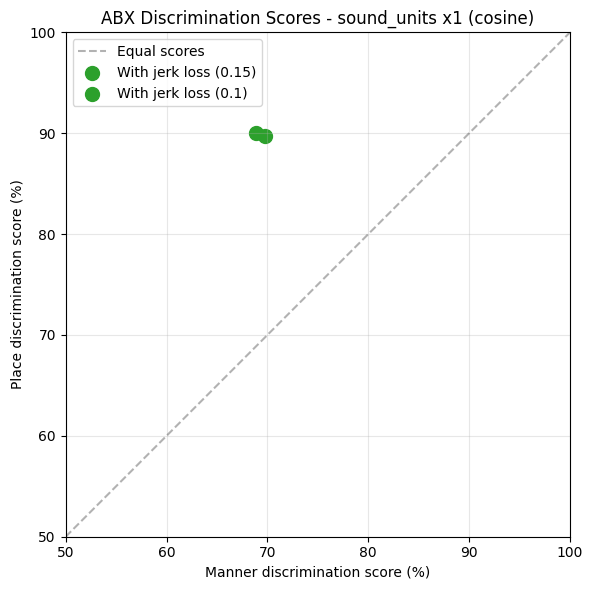


Analyzing ABX scores for distance metric: art_estimated x1 (euclidean)

Agent: pb2007 synth_art=art_params nd=0 jerk=0.15 (0)
Manner discrimination: 65.9%
Place discrimination: 82.8%

Agent: pb2007 synth_art=art_params nd=0 jerk=0.1 (0)
Manner discrimination: 65.2%
Place discrimination: 83.2%


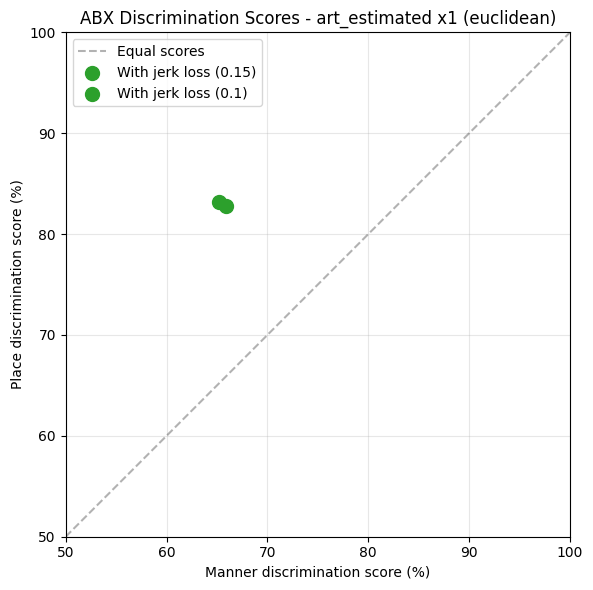

In [20]:
# Plot ABX scores for each distance metric
for distance in AGENT_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    print(f"\nAnalyzing ABX scores for distance metric: {distance_signature}")
    
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(aspect="equal")
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner discrimination score (%)")
    ax.set_ylabel("Place discrimination score (%)")
    
    ax.set_title(f"ABX Discrimination Scores - {distance_signature}")
    
    # Add diagonal line for reference
    ax.plot([50, 100], [50, 100], 'k--', alpha=0.3, label='Equal scores')
    
    for agent_alias, agent_path in agents_alias.items():
        agent = CommunicativeAgent.reload(agent_path, load_nn=False)
        dataset = agent.get_main_dataset()
        
        # Color based on whether jerk loss was used in training
        jerk_weight = agent.config["training"]["jerk_loss_weight"]
        color = "tab:green" if jerk_weight > 0 else "tab:red"
        label = f"With jerk loss ({jerk_weight})" if jerk_weight > 0 else "Without jerk loss"

        agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
        agent_groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, dataset.phones_infos["consonant_groups"])
        
        # Print scores for this agent
        print(f"\nAgent: {agent_alias}")
        print(f"Manner discrimination: {agent_groups_score['manner']:.1f}%")
        print(f"Place discrimination: {agent_groups_score['place']:.1f}%")
        
        ax.scatter(agent_groups_score["manner"], agent_groups_score["place"], 
                  c=color, label=label, s=100)

    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()